In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import math
import pickle
from scipy import stats
import matplotlib.patches as patches
from matplotlib import lines
import scipy

In [4]:
phen_noncog = ['ASR_Extn_T', 'ASR_Intn_T', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_E', 'NEOFAC_A', 'ASR_Attn_Pct',
                     'NEOFAC_N', 'DDisc_AUC_40K', 'MMSE_Score', 'PSQI_Score', 'Endurance_Unadj', 'GaitSpeed_Comp',
                     'Dexterity_Unadj', 'Strength_Unadj', 'Odor_Unadj', 'PainInterf_Tscore', 'Taste_Unadj', 'Mars_Final', 
                     'Emotion_Task_Face_Acc', 'Language_Task_Story_Avg_Difficulty_Level', 'Social_Task_Perc_Random', 
                     'Social_Task_Perc_TOM', 'ER40_CR', 'ER40ANG', 'ER40FEAR', 'ER40NOE', 'ER40SAD', 'AngAffect_Unadj', 
                     'AngHostil_Unadj', 'AngAggr_Unadj', 'FearAffect_Unadj', 'FearSomat_Unadj', 'Sadness_Unadj', 'LifeSatisf_Unadj',
                     'MeanPurp_Unadj', 'PosAffect_Unadj', 'Friendship_Unadj', 'Loneliness_Unadj', 'PercHostil_Unadj', 'PercReject_Unadj',
                     'EmotSupp_Unadj', 'InstruSupp_Unadj', 'PercStress_Unadj', 'SelfEff_Unadj']

phen_cog = ['PMAT24_A_CR', 'ProcSpeed_Unadj', 'PicSeq_Unadj', 'CardSort_Unadj', 'Flanker_Unadj', 'ListSort_Unadj', 'ReadEng_Unadj',
                  'PicVocab_Unadj', 'SCPT_SEN', 'SCPT_SPEC', 'IWRD_TOT', 'VSPLOT_TC', 'Language_Task_Math_Avg_Difficulty_Level', 'WM_Task_Acc']

all_phen = list(np.concatenate((phen_cog, phen_noncog)))
all_phen.append('GenExec')
all_phen.append('ProcSpeed')

### The following cell outputs table of summary statistics for ICC, accuracy and ICC ~ accuracy

In [5]:
# manually change any of the 3 parameters below
data_type = 'volume'  # one of {volume, cifti}
n_mins = '15'  # one of {15, 7, 3}, note 15 means 14.5 mins of run-length for each day => 29 minutes of resting state data across 2 day/sessions
# likewise n_mins = 7 means 7.5 minutes of run data from each day => 15 minutes of resting state data across 2 sessions
# and n_mins = 3 means 3.75 minutes of run data from each day => 7.5 minutes of resting state data across 2 sessions
fd_thresh = '5'  # FD threshold, 5 = 0.5mm, 2 = 0.2mm

# code below should not need to be adjusted
BBS75_results = pickle.load(open(f'../saved_models/{data_type}/BBS75_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
Lasso_results = pickle.load(open(f'../saved_models/{data_type}/Lasso_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
Ridge_results = pickle.load(open(f'../saved_models/{data_type}/Ridge_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
CPMPos_results = pickle.load(open(f'../saved_models/{data_type}/CPMPos_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
CPMNeg_results = pickle.load(open(f'../saved_models/{data_type}/CPMNeg_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
BBSCV_results = pickle.load(open(f'../saved_models/{data_type}/BBSCV_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
Enet_results = pickle.load(open(f'../saved_models/{data_type}/ENet_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
SVRLin_results = pickle.load(open(f'../saved_models/{data_type}/SVRLin_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
SVRNonLin_results = pickle.load(open(f'../saved_models/{data_type}/SVRNonLin_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
RF_results = pickle.load(open(f'../saved_models/{data_type}/RF_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))

all_results = [BBS75_results, BBSCV_results, Lasso_results, Ridge_results, CPMPos_results, CPMNeg_results, Enet_results, SVRLin_results, SVRNonLin_results, RF_results]
results_names = ['BBS-\n75', 'BBS-\nCV', 'Lasso', 'Ridge', 'CPM+', 'CPM-', 'ENet', 'SVR-\nLin', 'SVR-\nNonLin', ' Rand\n Forest']


model_icc_acc_dict = dict()
for name in results_names:
    model_icc_acc_dict[name] = dict()
    model_icc_acc_dict[name]['mean_phen_icc'] = []
    model_icc_acc_dict[name]['mean_phen_acc'] = []

for model_result, model_name in zip(all_results, results_names):
    for phen in all_phen:
        folds_scores, sess1_folds_preds, sess2_folds_preds, models = model_result[phen]
        model_icc_acc_dict[model_name]['mean_phen_icc'].append(np.mean([x[0] for x in [x for y in folds_scores for x in y]]))
        model_icc_acc_dict[model_name]['mean_phen_acc'].append((np.nanmean([x[2] for x in [x for y in folds_scores for x in y]]) + np.nanmean([x[3] for x in [x for y in folds_scores for x in y]]))/2)
        
model_icc_acc_dict_cog = dict()
for name in results_names:
    model_icc_acc_dict_cog[name] = dict()
    model_icc_acc_dict_cog[name]['mean_phen_icc'] = []
    model_icc_acc_dict_cog[name]['mean_phen_acc'] = []

for model_result, model_name in zip(all_results, results_names):
    for phen in phen_cog:
        folds_scores, sess1_folds_preds, sess2_folds_preds, models = model_result[phen]
        model_icc_acc_dict_cog[model_name]['mean_phen_icc'].append(np.mean([x[0] for x in [x for y in folds_scores for x in y]]))
        model_icc_acc_dict_cog[model_name]['mean_phen_acc'].append((np.nanmean([x[2] for x in [x for y in folds_scores for x in y]]) + np.nanmean([x[3] for x in [x for y in folds_scores for x in y]]))/2)
        
model_icc_acc_dict_noncog = dict()
for name in results_names:
    model_icc_acc_dict_noncog[name] = dict()
    model_icc_acc_dict_noncog[name]['mean_phen_icc'] = []
    model_icc_acc_dict_noncog[name]['mean_phen_acc'] = []

for model_result, model_name in zip(all_results, results_names):
    for phen in phen_noncog:
        folds_scores, sess1_folds_preds, sess2_folds_preds, models = model_result[phen]
        model_icc_acc_dict_noncog[model_name]['mean_phen_icc'].append(np.mean([x[0] for x in [x for y in folds_scores for x in y]]))
        model_icc_acc_dict_noncog[model_name]['mean_phen_acc'].append((np.nanmean([x[2] for x in [x for y in folds_scores for x in y]]) + np.nanmean([x[3] for x in [x for y in folds_scores for x in y]]))/2)
        
mu_iccs = []
for x in model_icc_acc_dict:
    mu_iccs.append((x, np.mean(model_icc_acc_dict[x]["mean_phen_icc"])))
sorted_model_names = sorted(mu_iccs, key=lambda x: x[1], reverse=True)
sorted_model_names = [x[0] for x in sorted_model_names]
    
    
print_x = 'Model Name'
print_y = 'Mean ICC'
print_z = 'Mean Acc'
print_a = 'Sdev ICC'
print_b = 'Min ICC'
print_c = 'Max ICC'
print_d = 'Cog Acc'
print_e = ' NonCog Acc'
print_f = 'rel~acc'
print_g = 'pvalue'
print(f'{print_x:<11} {print_y:>10} {print_z:>10} {print_a:>10} {print_b:>10} {print_c:>10} {print_d:>10} {print_e:>10} {print_f:>10} {print_g:>10}')
for x in sorted_model_names:
    print_x = x.replace('\n', '')
    if 'Forest' in print_x:
        print_x = 'Rand Forest'
    nan_filtered_icc_acc = [(i, a) for i, a in zip(model_icc_acc_dict[x]["mean_phen_icc"], model_icc_acc_dict[x]["mean_phen_acc"]) if (not math.isnan(i)) and (not math.isnan(a))]
    rel_acc_r = stats.pearsonr([x[0] for x in nan_filtered_icc_acc], [x[1] for x in nan_filtered_icc_acc])
    print(f'{print_x:<11} {np.nanmean(model_icc_acc_dict[x]["mean_phen_icc"]):>10.3f} {np.nanmean(model_icc_acc_dict[x]["mean_phen_acc"]):>10.3f} {np.nanstd(model_icc_acc_dict[x]["mean_phen_icc"]):>10.3f} \
{np.nanmin(model_icc_acc_dict[x]["mean_phen_icc"]):>10.3f} {np.nanmax(model_icc_acc_dict[x]["mean_phen_icc"]):>10.3f} {np.nanmean(model_icc_acc_dict_cog[x]["mean_phen_acc"]):>10.3f} \
{np.nanmean(model_icc_acc_dict_noncog[x]["mean_phen_acc"]):>10.3f} {rel_acc_r[0]:>10.3f}     {rel_acc_r[1]:>10.3e}')

Model Name    Mean ICC   Mean Acc   Sdev ICC    Min ICC    Max ICC    Cog Acc  NonCog Acc    rel~acc     pvalue
BBS-75           0.740      0.107      0.043      0.648      0.878      0.172      0.080      0.521      1.660e-05
BBS-CV           0.732      0.108      0.041      0.643      0.849      0.166      0.083      0.579      1.039e-06
SVR-Lin          0.720      0.095      0.036      0.653      0.856      0.155      0.071      0.426      6.167e-04
SVR-NonLin       0.707      0.113      0.051      0.622      0.852      0.170      0.089      0.633      4.541e-08
ENet             0.674      0.117      0.085      0.489      0.860      0.181      0.090      0.746      5.252e-12
Ridge            0.673      0.118      0.085      0.489      0.862      0.181      0.091      0.745      5.702e-12
CPM+             0.641      0.092      0.075      0.509      0.806      0.136      0.072      0.517      2.003e-05
CPM-             0.598      0.079      0.062      0.451      0.750      0.112      

### The following 3 cells output volume/grayordinate ICC results for all predictive models

In [6]:
# manually change any of the 2 parameters below
n_mins = '15'  # one of {15, 7, 3}, note 15 means 14.5 mins of run-length for each day => 29 minutes of resting state data across 2 days (sessions
# likewise n_mins = 7 means 7.5 minutes of run data from each day => 15 minutes of resting state data across 2 sessions
# and n_mins = 3 means 3.75 minutes of run data from each day => 7.5 minutes of resting state data across 2 sessions
fd_thresh = '5'  # FD threshold, 5 = 0.5mm, 2 = 0.2mm

# no lines below or in the next two cells should need to be changed
data_type = 'volume'
icc_edges_volume = pickle.load(open('../saved_models/edgewise/volume_15min_5fd.pickle', 'rb'))
icc_edges_cifti = pickle.load(open('../saved_models/edgewise/cifti_15min_5fd.pickle', 'rb'))

BBS75_results = pickle.load(open(f'../saved_models/{data_type}/BBS75_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
Lasso_results = pickle.load(open(f'../saved_models/{data_type}/Lasso_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
Ridge_results = pickle.load(open(f'../saved_models/{data_type}/Ridge_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
CPMPos_results = pickle.load(open(f'../saved_models/{data_type}/CPMPos_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
CPMNeg_results = pickle.load(open(f'../saved_models/{data_type}/CPMNeg_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
BBSCV_results = pickle.load(open(f'../saved_models/{data_type}/BBSCV_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
Enet_results = pickle.load(open(f'../saved_models/{data_type}/ENet_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
SVRLin_results = pickle.load(open(f'../saved_models/{data_type}/SVRLin_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
SVRNonLin_results = pickle.load(open(f'../saved_models/{data_type}/SVRNonLin_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
RF_results = pickle.load(open(f'../saved_models/{data_type}/RF_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))

all_results = [BBS75_results, BBSCV_results, Lasso_results, Ridge_results, CPMPos_results, CPMNeg_results, Enet_results, SVRLin_results, SVRNonLin_results, RF_results]
results_names = ['BBS-\n75', 'BBS-\nCV', 'Lasso', 'Ridge', 'CPM+', 'CPM-', 'ENet', 'SVR-\nLin', 'SVR-\nNonLin', ' Rand\n Forest']
model_colors = ['C1', 'C0', 'C5', 'C4', 'C2', 'C3', 'C6', 'C7', 'C8', 'C9']

model_icc_acc_dict = dict()
for name in results_names:
    model_icc_acc_dict[name] = dict()
    model_icc_acc_dict[name]['mean_phen_icc'] = []
    model_icc_acc_dict[name]['mean_phen_acc'] = []

for model_result, model_name in zip(all_results, results_names):
    for phen in all_phen:
        folds_scores, sess1_folds_preds, sess2_folds_preds, models = model_result[phen]
        model_icc_acc_dict[model_name]['mean_phen_icc'].append(np.mean([x[0] for x in [x for y in folds_scores for x in y]]))
        model_icc_acc_dict[model_name]['mean_phen_acc'].append((np.nanmean([x[2] for x in [x for y in folds_scores for x in y]]) + np.nanmean([x[3] for x in [x for y in folds_scores for x in y]]))/2)
        
model_icc_acc_dict_cog = dict()
for name in results_names:
    model_icc_acc_dict_cog[name] = dict()
    model_icc_acc_dict_cog[name]['mean_phen_icc'] = []
    model_icc_acc_dict_cog[name]['mean_phen_acc'] = []

for model_result, model_name in zip(all_results, results_names):
    for phen in phen_cog:
        folds_scores, sess1_folds_preds, sess2_folds_preds, models = model_result[phen]
        model_icc_acc_dict_cog[model_name]['mean_phen_icc'].append(np.mean([x[0] for x in [x for y in folds_scores for x in y]]))
        model_icc_acc_dict_cog[model_name]['mean_phen_acc'].append((np.nanmean([x[2] for x in [x for y in folds_scores for x in y]]) + np.nanmean([x[3] for x in [x for y in folds_scores for x in y]]))/2)
        
model_icc_acc_dict_noncog = dict()
for name in results_names:
    model_icc_acc_dict_noncog[name] = dict()
    model_icc_acc_dict_noncog[name]['mean_phen_icc'] = []
    model_icc_acc_dict_noncog[name]['mean_phen_acc'] = []

for model_result, model_name in zip(all_results, results_names):
    for phen in phen_noncog:
        folds_scores, sess1_folds_preds, sess2_folds_preds, models = model_result[phen]
        model_icc_acc_dict_noncog[model_name]['mean_phen_icc'].append(np.mean([x[0] for x in [x for y in folds_scores for x in y]]))
        model_icc_acc_dict_noncog[model_name]['mean_phen_acc'].append((np.nanmean([x[2] for x in [x for y in folds_scores for x in y]]) + np.nanmean([x[3] for x in [x for y in folds_scores for x in y]]))/2)
        
ICC_vals_volume = [model_icc_acc_dict[model_name]['mean_phen_icc'] for model_name in results_names]

In [7]:
data_type = 'cifti'

BBS75_results = pickle.load(open(f'../saved_models/{data_type}/BBS75_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
Lasso_results = pickle.load(open(f'../saved_models/{data_type}/Lasso_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
Ridge_results = pickle.load(open(f'../saved_models/{data_type}/Ridge_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
CPMPos_results = pickle.load(open(f'../saved_models/{data_type}/CPMPos_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
CPMNeg_results = pickle.load(open(f'../saved_models/{data_type}/CPMNeg_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
BBSCV_results = pickle.load(open(f'../saved_models/{data_type}/BBSCV_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
Enet_results = pickle.load(open(f'../saved_models/{data_type}/ENet_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
SVRLin_results = pickle.load(open(f'../saved_models/{data_type}/SVRLin_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
SVRNonLin_results = pickle.load(open(f'../saved_models/{data_type}/SVRNonLin_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
RF_results = pickle.load(open(f'../saved_models/{data_type}/RF_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))

all_results = [BBS75_results, BBSCV_results, Lasso_results, Ridge_results, CPMPos_results, CPMNeg_results, Enet_results, SVRLin_results, SVRNonLin_results, RF_results]
results_names = ['BBS-\n75', 'BBS-\nCV', 'Lasso', 'Ridge', 'CPM+', 'CPM-', 'ENet', 'SVR-\nLin', 'SVR-\nNonLin', ' Rand\n Forest']
model_colors = ['C1', 'C0', 'C5', 'C4', 'C2', 'C3', 'C6', 'C7', 'C8', 'C9']

model_icc_acc_dict = dict()
for name in results_names:
    model_icc_acc_dict[name] = dict()
    model_icc_acc_dict[name]['mean_phen_icc'] = []
    model_icc_acc_dict[name]['mean_phen_acc'] = []

for model_result, model_name in zip(all_results, results_names):
    for phen in all_phen:
        folds_scores, sess1_folds_preds, sess2_folds_preds, models = model_result[phen]
        model_icc_acc_dict[model_name]['mean_phen_icc'].append(np.mean([x[0] for x in [x for y in folds_scores for x in y]]))
        model_icc_acc_dict[model_name]['mean_phen_acc'].append((np.nanmean([x[2] for x in [x for y in folds_scores for x in y]]) + np.nanmean([x[3] for x in [x for y in folds_scores for x in y]]))/2)
        
model_icc_acc_dict_cog = dict()
for name in results_names:
    model_icc_acc_dict_cog[name] = dict()
    model_icc_acc_dict_cog[name]['mean_phen_icc'] = []
    model_icc_acc_dict_cog[name]['mean_phen_acc'] = []

for model_result, model_name in zip(all_results, results_names):
    for phen in phen_cog:
        folds_scores, sess1_folds_preds, sess2_folds_preds, models = model_result[phen]
        model_icc_acc_dict_cog[model_name]['mean_phen_icc'].append(np.mean([x[0] for x in [x for y in folds_scores for x in y]]))
        model_icc_acc_dict_cog[model_name]['mean_phen_acc'].append((np.nanmean([x[2] for x in [x for y in folds_scores for x in y]]) + np.nanmean([x[3] for x in [x for y in folds_scores for x in y]]))/2)
        
model_icc_acc_dict_noncog = dict()
for name in results_names:
    model_icc_acc_dict_noncog[name] = dict()
    model_icc_acc_dict_noncog[name]['mean_phen_icc'] = []
    model_icc_acc_dict_noncog[name]['mean_phen_acc'] = []

for model_result, model_name in zip(all_results, results_names):
    for phen in phen_noncog:
        folds_scores, sess1_folds_preds, sess2_folds_preds, models = model_result[phen]
        model_icc_acc_dict_noncog[model_name]['mean_phen_icc'].append(np.mean([x[0] for x in [x for y in folds_scores for x in y]]))
        model_icc_acc_dict_noncog[model_name]['mean_phen_acc'].append((np.nanmean([x[2] for x in [x for y in folds_scores for x in y]]) + np.nanmean([x[3] for x in [x for y in folds_scores for x in y]]))/2)
        
ICC_vals_cifti = [model_icc_acc_dict[model_name]['mean_phen_icc'] for model_name in results_names]

/home/ataxali/anaconda3/envs/sripada_lab/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/home/ataxali/anaconda3/envs/sripada_lab/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice


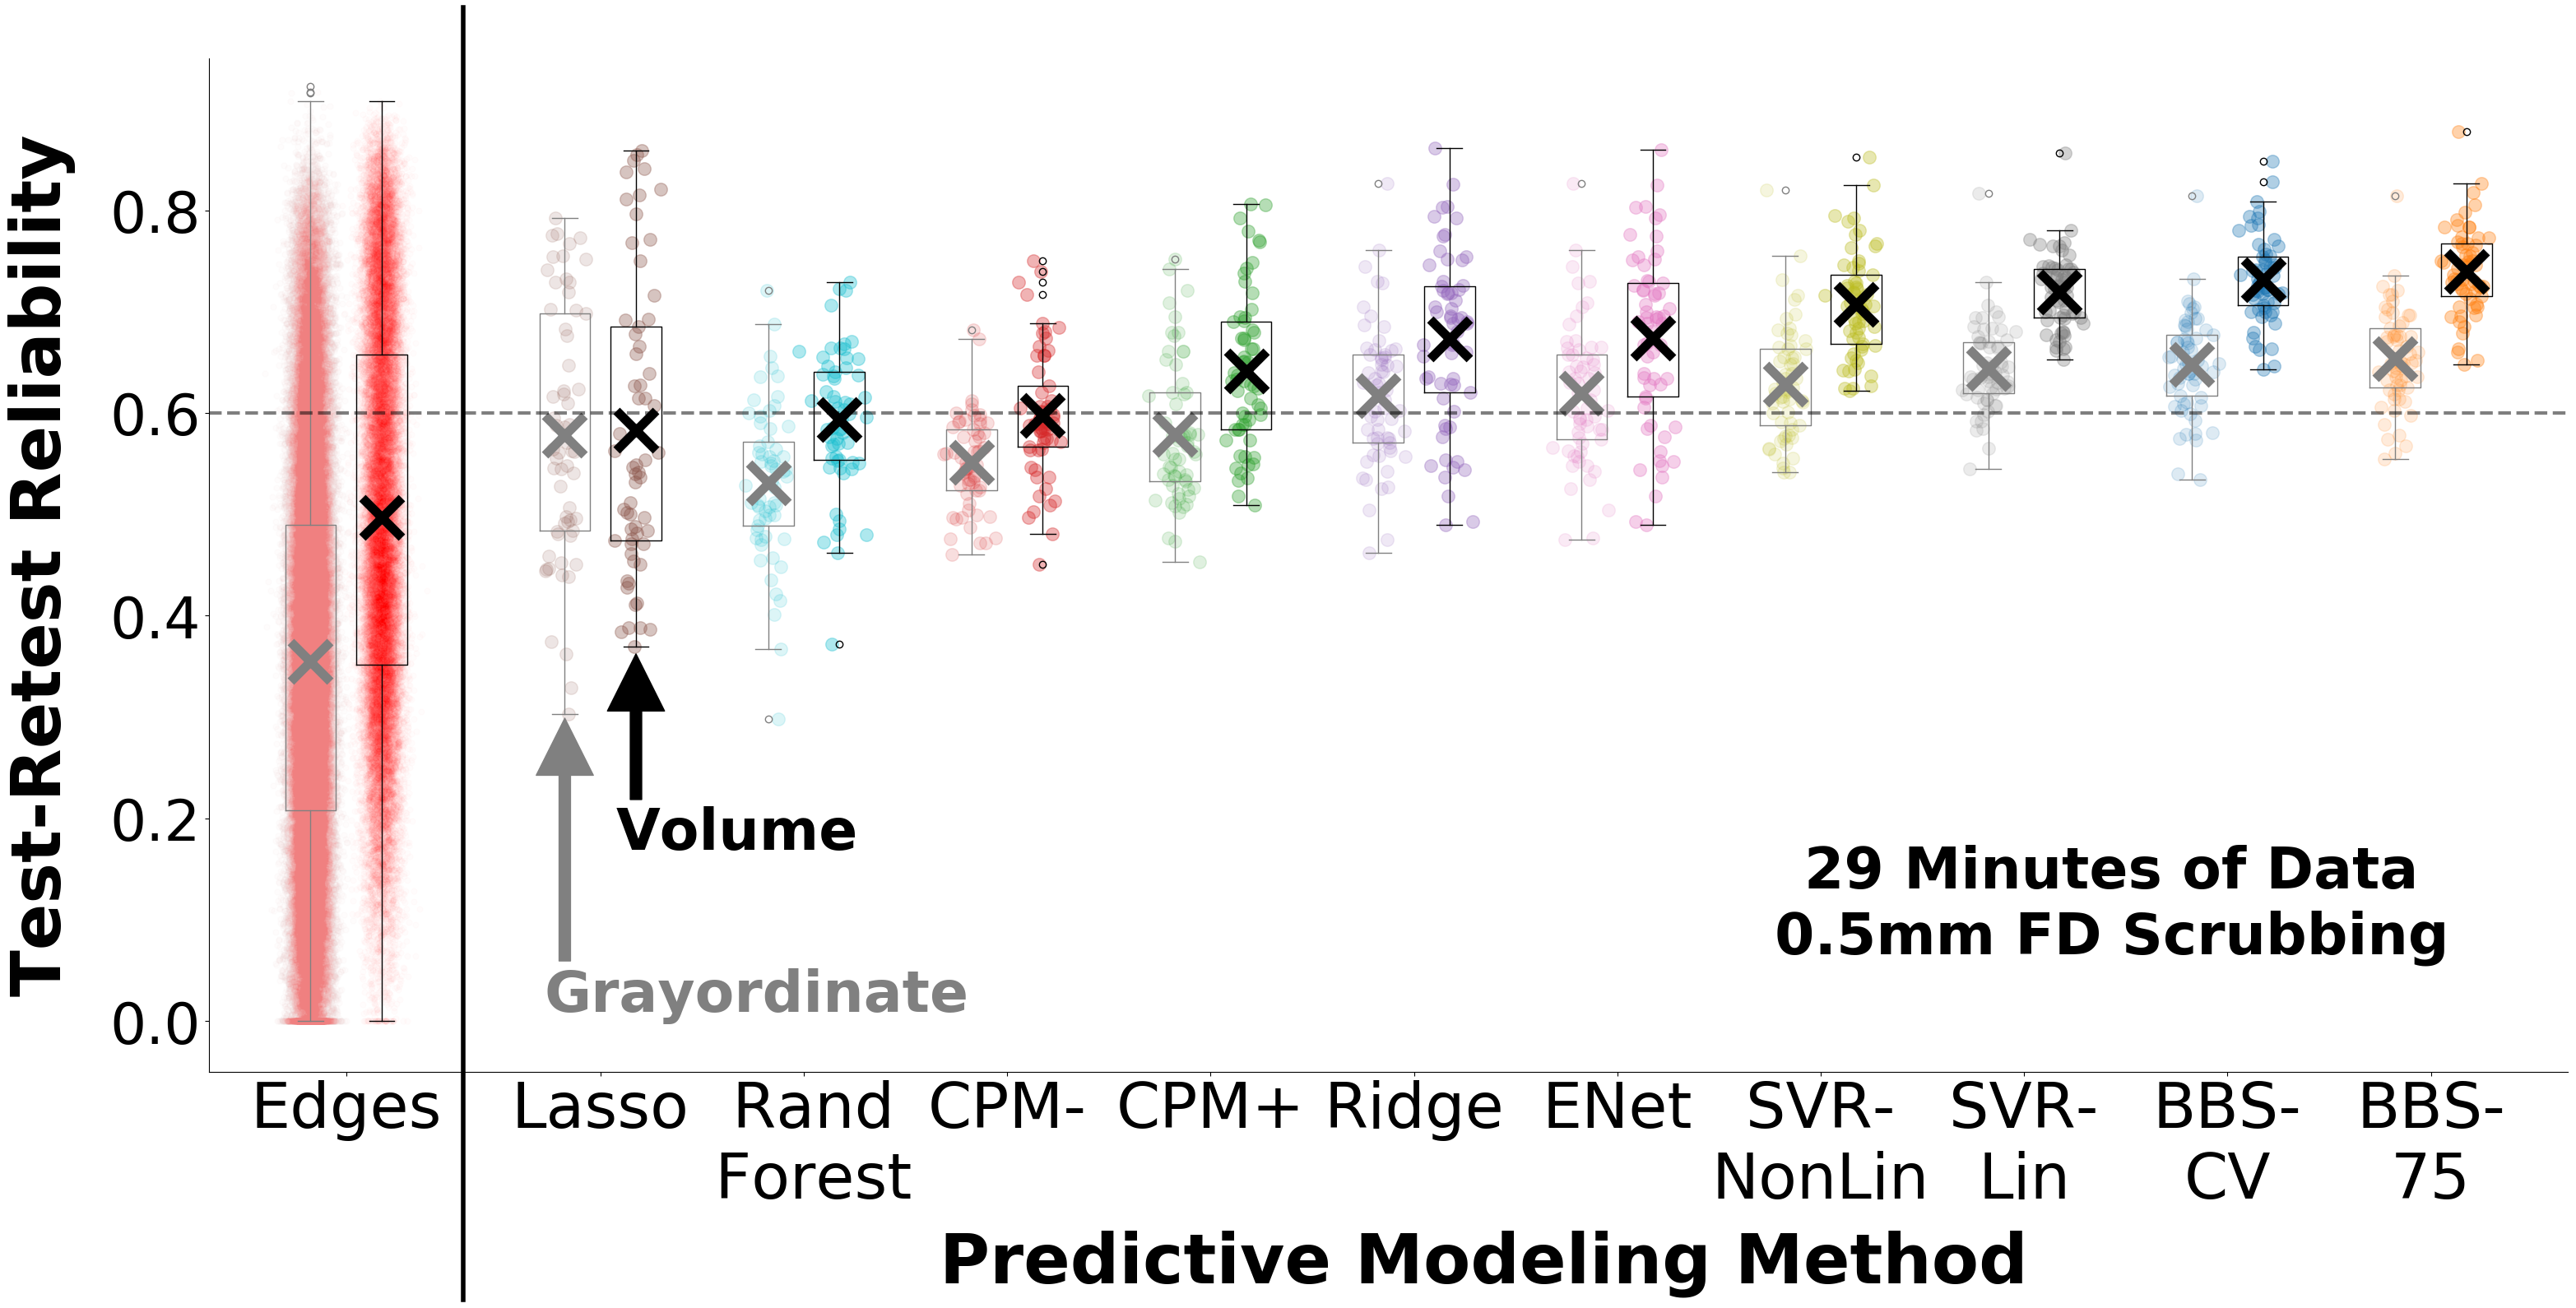

In [8]:
colors = model_colors
names = results_names
model_order = np.argsort([np.mean(x) for x in ICC_vals_volume])

names_sorted = [names[i] for i in model_order]
colors_sorted = [colors[i] for i in model_order]
ICC_vals_volume_sorted = [ICC_vals_volume[i] for i in model_order]
ICC_vals_cifti_sorted = [ICC_vals_cifti[i] for i in model_order]

ICC_vals_volume_sorted.insert(0, icc_edges_volume)
ICC_vals_cifti_sorted.insert(0, icc_edges_cifti)
names_sorted.insert(0, 'Edges')
colors_sorted.insert(0, 'r')


fig, ax = plt.subplots(figsize=(37, 16))
xpos = np.arange(len(ICC_vals_volume_sorted)).astype(np.float)
xpos[0] = -0.25


medianprops = dict(linestyle='-.', linewidth=0, color='firebrick')
meanlineprops = dict(linestyle='-', linewidth=0, color='k')
plt.boxplot(ICC_vals_volume_sorted,
            positions = xpos + 0.35,
            labels=['' for _ in range(len(ICC_vals_cifti_sorted))],
            showmeans=True, meanline=True, meanprops=meanlineprops, medianprops=medianprops, widths=0.25)
c = 'gray'
plt.boxplot(ICC_vals_cifti_sorted,
            positions = xpos, #np.arange(len(ICC_vals_volume_sorted)),
            labels=['' for _ in range(len(ICC_vals_cifti_sorted))],
            showmeans=True, meanline=True,
            meanprops=meanlineprops, medianprops=medianprops, 
            boxprops=dict(color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            widths=0.25)

plt.plot(xpos + 0.35, 
         [np.mean(x) for x in ICC_vals_volume_sorted],
         'rp', marker='x', c='k', markersize=35, markeredgewidth=8)
plt.plot(xpos, 
         [np.mean(x) for x in ICC_vals_cifti_sorted],
         'rp', marker='x', c='gray', markersize=35, markeredgewidth=8)

np.random.seed(42)
for i in range(len(ICC_vals_volume_sorted)):
    vals = ICC_vals_volume_sorted[i]
    alpha = 0.01 if i == 0 else 0.35
    s = 25 if i==0 else 125
    plt.scatter(np.array([xpos[i] for _ in vals]) + np.random.normal(0, 0.05, size=len(vals)) + 0.35, 
                vals, c=colors_sorted[i], alpha=alpha, s=s)
    
    vals = ICC_vals_cifti_sorted[i]
    alpha = 0.02 if i == 0 else 0.15
    s = 25 if i==0 else 125
    if i == 0:
        plt.scatter(np.array([xpos[i] for _ in vals]) + np.random.normal(0, 0.05, size=len(vals)), 
            vals, c='lightcoral', alpha=alpha, s=s)
    else:
        plt.scatter(np.array([i for _ in vals]) + np.random.normal(0, 0.05, size=len(vals)), 
                    vals, c=colors_sorted[i], alpha=alpha, s=s)

plt.ylabel('Test-Retest Reliability', fontsize=60, weight='bold', labelpad=30)

plt.axhline(y=0.6, color='k', linestyle='--', linewidth=3, alpha=0.5)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(55) 

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(50) 

if n_mins == '15':
    mins_str = '30'
elif n_mins == '7':
    mins_str = '15'
elif n_mins == '3':
    mins_str = '7.5'
else:
    raise Exception()
    
if data_type == 'volume':
    data_type_str = 'Volume'
elif data_type == 'cifti':
    data_type_str = 'Cifti'
else:
    raise Exception()


plt.gca().annotate('', fontsize=50, fontweight='bold', color='gray',
            xy=(1, 0.32), 
            xytext=(0, -250),    
            textcoords='offset points',
            arrowprops=dict(facecolor='gray', edgecolor='gray', width=10, shrink=0.075, headwidth=50, headlength=50),
            horizontalalignment='left',
            verticalalignment='top')    
plt.gca().annotate('', fontsize=50, fontweight='bold', color='k',
            xy=(1.35, 0.375), 
            xytext=(0, -150),   
            textcoords='offset points',
            arrowprops=dict(facecolor='k', edgecolor='k', width=10, shrink=0.075, headwidth=50, headlength=50),
            horizontalalignment='left',
            verticalalignment='top')   
plt.gca().text(0.9, 0.01, 'Grayordinate', fontsize=50, fontweight='bold', color='gray')
plt.gca().text(1.25, 0.17, 'Volume', fontsize=50, fontweight='bold', color='k')
plt.ylim((-0.05, 0.95))

plt.xticks((xpos + (xpos+0.35))/2, names_sorted)
fig.text(0.365, -0.05, 'Predictive Modeling Method', fontsize=60, weight='bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#rect = patches.Rectangle((-1, -1), 1.5, 2, linewidth=2, edgecolor='none', facecolor='lightgray', zorder=0, alpha=0.5)
#ax.add_patch(rect)

line = lines.Line2D([0.5, 0.5], [1, -0.275], lw=4, color='k', linestyle='-', alpha=1)
line.set_clip_on(False)
ax.add_line(line)

fig.text(0.75, 0.25, '29 Minutes of Data', fontsize=50, fontweight='bold', ha='center')
fig.text(0.75, 0.2, '0.5mm FD Scrubbing', fontsize=50, fontweight='bold', ha='center')

plt.show()

### The following two cells show ICCs for predicted outcomes across run-lengths and FD thresholds

/home/ataxali/anaconda3/envs/sripada_lab/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice


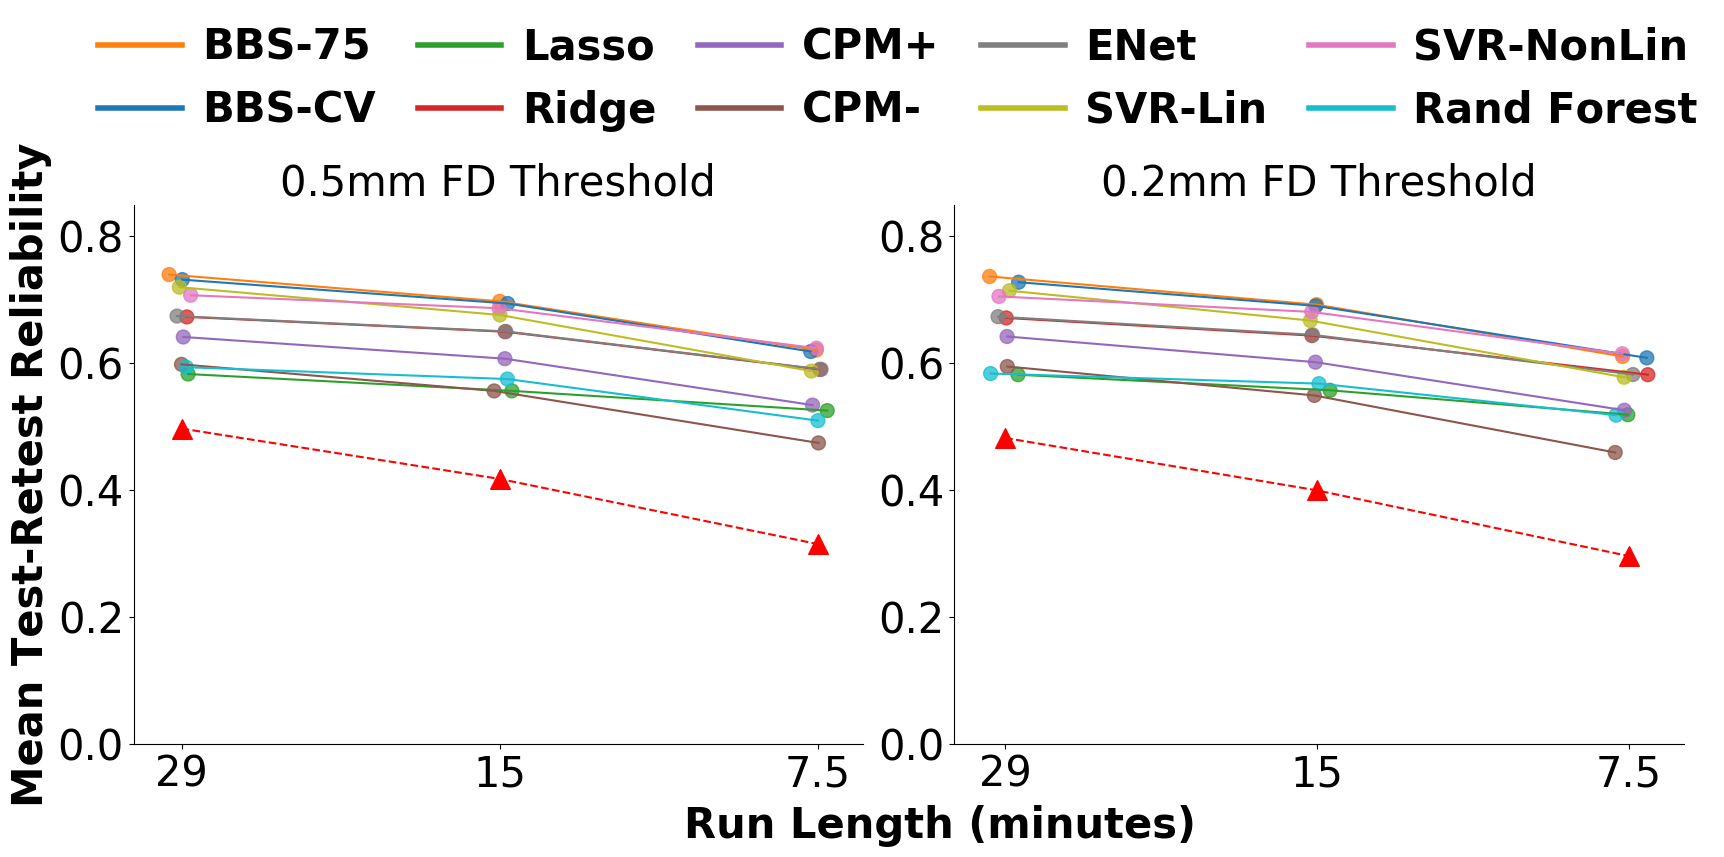

In [9]:
fig = plt.figure(figsize=(20, 7))
data_type = 'volume'

for subplot_i, fd_thresh in enumerate(['5', '2']):
    plt.subplot(1, 2, subplot_i+1)
    model_lines = dict()
    for model_name in results_names:
        model_lines[model_name] = dict()
    
    for i, n_mins in enumerate(['15', '7', '3']):
        BBS75_results = pickle.load(open(f'../saved_models/{data_type}/BBS75_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
        Lasso_results = pickle.load(open(f'../saved_models/{data_type}/Lasso_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
        Ridge_results = pickle.load(open(f'../saved_models/{data_type}/Ridge_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
        CPMPos_results = pickle.load(open(f'../saved_models/{data_type}/CPMPos_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
        CPMNeg_results = pickle.load(open(f'../saved_models/{data_type}/CPMNeg_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
        BBSCV_results = pickle.load(open(f'../saved_models/{data_type}/BBSCV_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
        Enet_results = pickle.load(open(f'../saved_models/{data_type}/ENet_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
        SVRLin_results = pickle.load(open(f'../saved_models/{data_type}/SVRLin_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
        SVRNonLin_results = pickle.load(open(f'../saved_models/{data_type}/SVRNonLin_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
        RF_results = pickle.load(open(f'../saved_models/{data_type}/RF_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))

        all_results = [BBS75_results, BBSCV_results, Lasso_results, Ridge_results, CPMPos_results, CPMNeg_results, Enet_results, SVRLin_results, SVRNonLin_results, RF_results]
        results_names = ['BBS-\n75', 'BBS-\nCV', 'Lasso', 'Ridge', 'CPM+', 'CPM-', 'ENet', 'SVR-\nLin', 'SVR-\nNonLin', ' Rand\n Forest']
        colors = ['C1', 'C0', 'C2', 'C3', 'C4', 'C5', 'C7', 'C8', 'C6', 'C9']

        model_icc_acc_dict = dict()
        for name in results_names:
            model_icc_acc_dict[name] = dict()
            model_icc_acc_dict[name]['mean_phen_icc'] = []
            model_icc_acc_dict[name]['mean_phen_acc'] = []

        for model_result, model_name in zip(all_results, results_names):
            for phen in all_phen:
                folds_scores, sess1_folds_preds, sess2_folds_preds, models = model_result[phen]
                model_icc_acc_dict[model_name]['mean_phen_icc'].append(np.mean([x[0] for x in [x for y in folds_scores for x in y]]))
                model_icc_acc_dict[model_name]['mean_phen_acc'].append((np.nanmean([x[2] for x in [x for y in folds_scores for x in y]]) + np.nanmean([x[3] for x in [x for y in folds_scores for x in y]]))/2)

        model_mus = [np.nanmean(model_icc_acc_dict[model_name]['mean_phen_icc']) for model_name in model_icc_acc_dict]
        x_offset = 0
        xvals = np.array([i for _ in range(len(model_mus))]) + np.random.normal(0, 0.025, len(model_mus)) + x_offset
        plt.scatter(xvals,
                    model_mus, s=100, alpha=0.75, c=colors)
        model_names = [model_name for model_name in model_icc_acc_dict]
        points = list(zip(xvals, model_mus))
        for model_name, point in zip(model_names, points):
            if data_type not in model_lines[model_name]:
                model_lines[model_name][data_type] = []
            model_lines[model_name][data_type].append(point)

    for i, model in enumerate(results_names):
        plt.plot([x[0] for x in model_lines[model][data_type]],
                 [x[1] for x in model_lines[model][data_type]], label=model.replace('\n', ' ').replace('  ', ' ').replace(' R', 'R').replace('- ', '-'),
                 c=colors[i])
    if subplot_i == 0:
        legend_properties = {'weight':'bold', 'size':30}
        lgnd = plt.legend(ncol=5, frameon=False, handletextpad=0.5, columnspacing=1, prop=legend_properties, bbox_to_anchor=(-0.1, 1.4), loc=2)
        for legobj in lgnd.legendHandles:
            legobj.set_linewidth(4)
        #plt.xlabel('Run Length (minutes)', fontsize=30, fontweight='bold')
        fig.text(0.4, -0.025, 'Run Length (minutes)', fontsize=30, fontweight='bold')
        plt.ylabel('Mean Test-Retest Reliability', fontsize=30, fontweight='bold')

    all_edge_res = []
    for i, n_mins in enumerate(['15', '7', '3']):
        edge_res = pickle.load(open(f'../saved_models/edgewise/{data_type}_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
        all_edge_res.append(np.nanmean(edge_res))
    
    plt.scatter(range(3), all_edge_res, marker="^", c='r', s=200)
    plt.plot(range(3), all_edge_res, linestyle='--', c='r')        
    
    plt.xticks(range(3), ['29', '15', '7.5'], fontsize=30)
    plt.yticks(np.arange(0, 0.85, 0.2), fontsize=30)
    plt.title(f'0.{fd_thresh}mm FD Threshold', fontsize=30, pad=-10)
    plt.ylim((0, 0.85))
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
plt.subplots_adjust(wspace=0.125)
plt.show()

/home/ataxali/anaconda3/envs/sripada_lab/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice


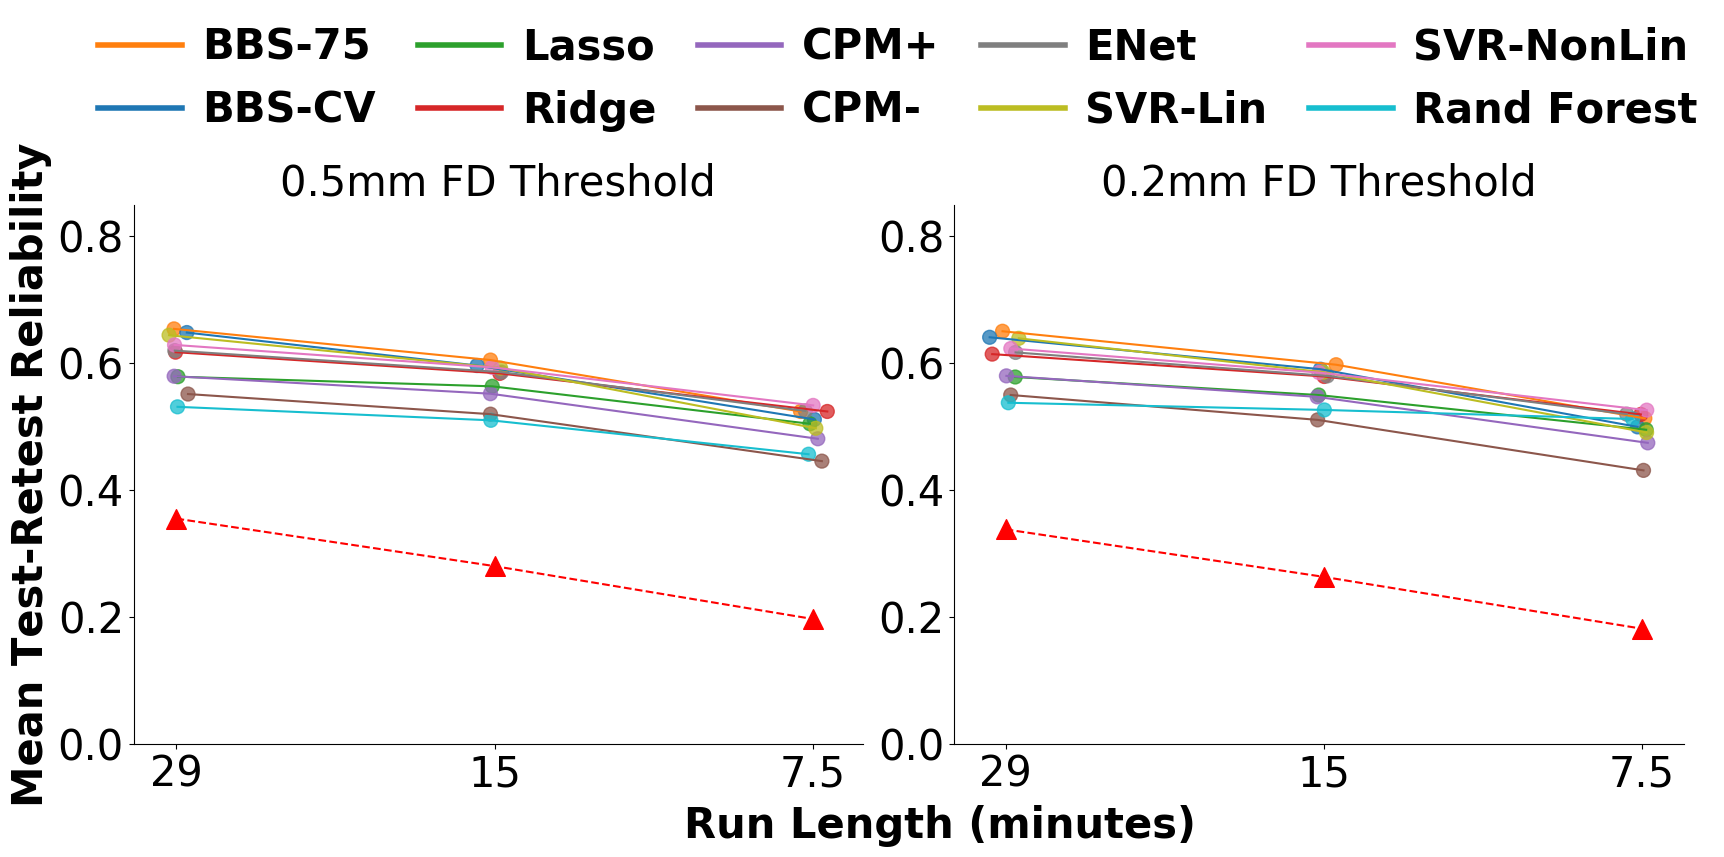

In [10]:
fig = plt.figure(figsize=(20, 7))
data_type = 'cifti'

for subplot_i, fd_thresh in enumerate(['5', '2']):
    plt.subplot(1, 2, subplot_i+1)
    model_lines = dict()
    for model_name in results_names:
        model_lines[model_name] = dict()
    
    for i, n_mins in enumerate(['15', '7', '3']):
        BBS75_results = pickle.load(open(f'../saved_models/{data_type}/BBS75_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
        Lasso_results = pickle.load(open(f'../saved_models/{data_type}/Lasso_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
        Ridge_results = pickle.load(open(f'../saved_models/{data_type}/Ridge_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
        CPMPos_results = pickle.load(open(f'../saved_models/{data_type}/CPMPos_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
        CPMNeg_results = pickle.load(open(f'../saved_models/{data_type}/CPMNeg_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
        BBSCV_results = pickle.load(open(f'../saved_models/{data_type}/BBSCV_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
        Enet_results = pickle.load(open(f'../saved_models/{data_type}/ENet_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
        SVRLin_results = pickle.load(open(f'../saved_models/{data_type}/SVRLin_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
        SVRNonLin_results = pickle.load(open(f'../saved_models/{data_type}/SVRNonLin_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
        RF_results = pickle.load(open(f'../saved_models/{data_type}/RF_results_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))

        all_results = [BBS75_results, BBSCV_results, Lasso_results, Ridge_results, CPMPos_results, CPMNeg_results, Enet_results, SVRLin_results, SVRNonLin_results, RF_results]
        results_names = ['BBS-\n75', 'BBS-\nCV', 'Lasso', 'Ridge', 'CPM+', 'CPM-', 'ENet', 'SVR-\nLin', 'SVR-\nNonLin', ' Rand\n Forest']
        colors = ['C1', 'C0', 'C2', 'C3', 'C4', 'C5', 'C7', 'C8', 'C6', 'C9']

        model_icc_acc_dict = dict()
        for name in results_names:
            model_icc_acc_dict[name] = dict()
            model_icc_acc_dict[name]['mean_phen_icc'] = []
            model_icc_acc_dict[name]['mean_phen_acc'] = []

        for model_result, model_name in zip(all_results, results_names):
            for phen in all_phen:
                folds_scores, sess1_folds_preds, sess2_folds_preds, models = model_result[phen]
                model_icc_acc_dict[model_name]['mean_phen_icc'].append(np.mean([x[0] for x in [x for y in folds_scores for x in y]]))
                model_icc_acc_dict[model_name]['mean_phen_acc'].append((np.nanmean([x[2] for x in [x for y in folds_scores for x in y]]) + np.nanmean([x[3] for x in [x for y in folds_scores for x in y]]))/2)

        model_mus = [np.nanmean(model_icc_acc_dict[model_name]['mean_phen_icc']) for model_name in model_icc_acc_dict]
        x_offset = 0
        xvals = np.array([i for _ in range(len(model_mus))]) + np.random.normal(0, 0.025, len(model_mus)) + x_offset
        plt.scatter(xvals,
                    model_mus, s=100, alpha=0.75, c=colors)
        model_names = [model_name for model_name in model_icc_acc_dict]
        points = list(zip(xvals, model_mus))
        for model_name, point in zip(model_names, points):
            if data_type not in model_lines[model_name]:
                model_lines[model_name][data_type] = []
            model_lines[model_name][data_type].append(point)

    for i, model in enumerate(results_names):
        plt.plot([x[0] for x in model_lines[model][data_type]],
                 [x[1] for x in model_lines[model][data_type]], label=model.replace('\n', ' ').replace('  ', ' ').replace(' R', 'R').replace('- ', '-'),
                 c=colors[i])
    if subplot_i == 0:
        legend_properties = {'weight':'bold', 'size':30}
        lgnd = plt.legend(ncol=5, frameon=False, handletextpad=0.5, columnspacing=1, prop=legend_properties, bbox_to_anchor=(-0.1, 1.4), loc=2)
        for legobj in lgnd.legendHandles:
            legobj.set_linewidth(4)
        #plt.xlabel('Run Length (minutes)', fontsize=30, fontweight='bold')
        fig.text(0.4, -0.025, 'Run Length (minutes)', fontsize=30, fontweight='bold')
        plt.ylabel('Mean Test-Retest Reliability', fontsize=30, fontweight='bold')

    all_edge_res = []
    for i, n_mins in enumerate(['15', '7', '3']):
        edge_res = pickle.load(open(f'../saved_models/edgewise/{data_type}_{n_mins}min_{fd_thresh}fd.pickle', 'rb'))
        all_edge_res.append(np.nanmean(edge_res))
    
    plt.scatter(range(3), all_edge_res, marker="^", c='r', s=200)
    plt.plot(range(3), all_edge_res, linestyle='--', c='r')        
    
    plt.xticks(range(3), ['29', '15', '7.5'], fontsize=30)
    plt.yticks(np.arange(0, 0.85, 0.2), fontsize=30)
    plt.title(f'0.{fd_thresh}mm FD Threshold', fontsize=30, pad=-10)
    plt.ylim((0, 0.85))
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
plt.subplots_adjust(wspace=0.125)
plt.show()